# TODOS:
## Target: 

1. get m_bbll distribution

2. next, get m_bl using *best pair*

$m_{bl}^{minimax}  = min(max(m_{b1l1},m_{b2l1}), max(m_{b1l2},m_{b2l2}))$




1. read from TTree 'nominal'

2. get into the entry

3. constructure LorenzVector for e, mu, b-jet

4. get m_llbb

5. fill Hist for ee, mumu, emu, all process

In [19]:
import os,shutil
import numpy as np
import ROOT
# os.system("source /cvmfs/atlas.cern.ch/repo/ATLASLocalRootBase/user/atlasLocalSetup.sh")
# os.system("lsetup \"views LCG_97 x86_64-centos7-gcc8-opt\"")
from ROOT import TCanvas, TLegend, TFile, TPaveLabel, TPaveText, TTree, TLorentzVector, TH1D, TVectorT, gStyle, THStack, gPad, TH2D
from ROOT import gROOT

import helper

In [20]:
# 1. get tfile
filename = "user.cgarvey.32744802._000002.output.root"
file = TFile(filename)
# 2. get ttree
nominal = file.Get("nominal")

In [21]:
# 3. def TH1 to fill
m_mu   = TH1D ("m_mu ","invariant mass of muon" ,100 ,50 ,200)
m_el   = TH1D ("m_el ","invariant mass of electron" ,100 ,-200 ,200)
m_bjet = TH1D ("m_bjet ","invariant mass of b_jet" ,100 ,0 ,100)
m_bbee = TH1D ("m_bbee ","invariant mass of bbee" , 50 ,100 ,700)
m_bbme = TH1D ("m_bbml ","invariant mass of bbme" , 50 ,100 ,700)
m_bbmm = TH1D ("m_bbmm ","invariant mass of bbee" , 50 ,100 ,700)
m_bl1  = TH1D ("m_bl1 ","invariant mass of bl pair by minimax" ,50 ,0 ,300)
m_bl2  = TH1D ("m_bl2 ","invariant mass of left bl pair" , 50 ,0 ,300)
m_lb   = TH2D ("m_lb", "masses of two lb pairs (fix l for max lb)", 50 ,0 ,300, 50 ,0 ,300)
m_bl   = TH2D ("m_bl", "masses of two lb pairs (fix b for max bl)", 50 ,0 ,300, 50 ,0 ,300)

In [22]:
# reset the TH1 before starting fill, so that previous running of this cell won't affect the result
m_mu.Reset()
m_el.Reset()
m_bjet.Reset()
m_bl1.Reset()
m_bl2.Reset()
m_lb.Reset()
m_bl.Reset()

In [23]:
# analysis events
# for n in range(nominal.GetEntries()):
for n in range(5000):
    nominal.GetEntry(n)
    p4s_el = helper.GetLorenzP4List(nominal,'el')
    for ip in range(len(p4s_el)):
        m_el.Fill(p4s_el[ip].M())

    p4s_mu = helper.GetLorenzP4List(nominal,'mu')
    for ip in range(len(p4s_mu)):
        m_mu.Fill(p4s_mu[ip].M())

    p4s_lep = helper.getp4s_lep(p4s_el, p4s_mu)

    p4s_bjet = helper.GetLorenzP4List(nominal,'bjet')
    for ip in range(len(p4s_bjet)):
        m_bjet.Fill(p4s_bjet[ip].M()/1000) # use GeV as unit

    if len(p4s_lep) != 2 or len(p4s_bjet) != 2: continue

    # elel = 1, elmu = 2, mumu = 3, invalid event = 0
    if helper.W_to_which(p4s_el, p4s_mu) == 1:
        p4sys = p4s_el[0]+p4s_el[1]+p4s_bjet[0]+p4s_bjet[1]
        m_bbee.Fill(p4sys.M()/1000) # in GeV
    elif helper.W_to_which(p4s_el, p4s_mu) == 2:
        p4sys = p4s_el[0]+p4s_mu[0]+p4s_bjet[0]+p4s_bjet[1]
        m_bbme.Fill(p4sys.M()/1000)
    elif helper.W_to_which(p4s_el, p4s_mu) == 3:
        p4sys = p4s_mu[0]+p4s_mu[1]+p4s_bjet[0]+p4s_bjet[1]
        m_bbmm.Fill(p4sys.M()/1000)
    
    idx_l, idx_b = helper.minimax(p4s_lep, p4s_bjet)
    # mass for minimax pair
    m_bl1.Fill((p4s_lep[idx_l] + p4s_bjet[idx_b]).M()/1000)
    # mass for the pair left
    m_bl2.Fill((p4s_lep[1 - idx_l] + p4s_bjet[1 - idx_b]).M()/1000)
    # x-axis for minimax pair, y for another pair
    m_lb.Fill((p4s_lep[idx_l] + p4s_bjet[idx_b]).M()/1000, (p4s_lep[1 - idx_l] + p4s_bjet[1 - idx_b]).M()/1000)

    idx_b, idx_l = helper.minimax(p4s_bjet, p4s_lep)
    # x-axis for minimax pair, y for another pair
    m_bl.Fill((p4s_lep[idx_l] + p4s_bjet[idx_b]).M()/1000, (p4s_lep[1 - idx_l] + p4s_bjet[1 - idx_b]).M()/1000)





Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


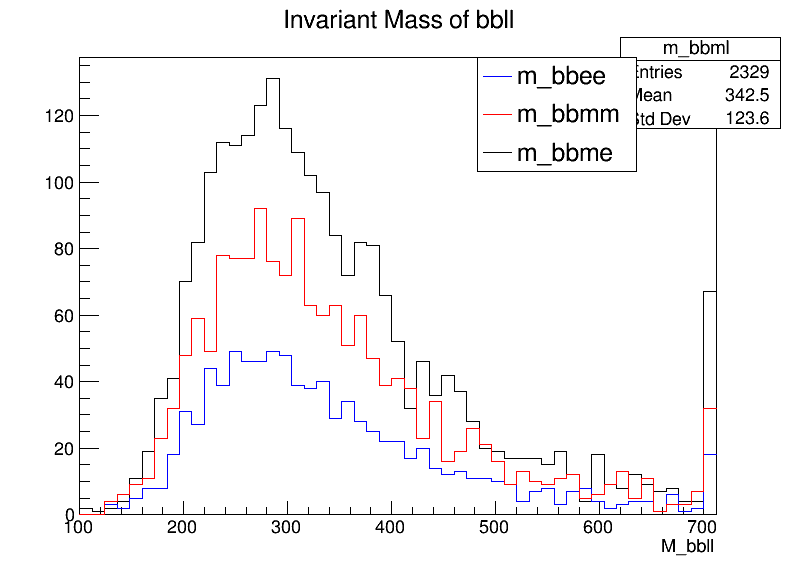

In [24]:
# plot

c1 = TCanvas('c1', 'canvas1', 0, 0, 800, 600 )

m_bbme.GetXaxis().SetRangeUser(100,720) 
m_bbmm.GetXaxis().SetRangeUser(100,720) 
m_bbee.GetXaxis().SetRangeUser(100,720) 

# add the range of next bin to include the overflow bin on when TH1.draw()


# gStyle.SetOptStat(0) # delete default legend for TH1

m_bbme.SetTitle("Invariant Mass of bbll")
m_bbme.GetXaxis().SetTitle("M_bbll")
m_bbme.SetLineColorAlpha(1, 1)
m_bbme.Draw()
m_bbee.SetLineColorAlpha(4, 1)
m_bbee.Draw('same')
m_bbmm.SetLineColorAlpha(2, 1)
m_bbmm.Draw('same')

leg = TLegend(0.6,0.7,0.8,0.9)
leg.AddEntry(m_bbee,"m_bbee","l")
leg.AddEntry(m_bbmm,"m_bbmm","l")
leg.AddEntry(m_bbme,"m_bbme","l")
leg.Draw()

c1.Draw()

In [ ]:
c2 = TCanvas('c2', 'canvas2', 0, 0, 800, 600 )
gStyle.SetOptStat(1)

hs = THStack("hs", "stacked m_bbll")
hs.Clear()

m_bbme.SetLineColor(ROOT.kRed)
m_bbme.SetFillColorAlpha(ROOT.kRed,0.5)
m_bbmm.SetLineColor(ROOT.kYellow)
m_bbmm.SetFillColorAlpha(ROOT.kYellow,0.5)
m_bbee.SetLineColor(ROOT.kBlue)
m_bbee.SetFillColorAlpha(ROOT.kBlue,0.5)

hs.Add(m_bbme)
hs.Add(m_bbmm)
hs.Add(m_bbee)


hs.Draw()
hs.GetXaxis().SetLimits(100,720) 

leg2 = TLegend(0.6,0.5,0.8,0.7)
leg2.AddEntry(m_bbee,"m_bbee","f")
leg2.AddEntry(m_bbmm,"m_bbmm","f")
leg2.AddEntry(m_bbme,"m_bbme","f")

leg2.Draw()

c2.Draw()

## bl pair by minimax:

$m_{bl}^{minimax}  = min\{max(m_{b1l1},m_{b2l1}), max(m_{b1l2},m_{b2l2})\}$



Warning in <TCanvas::Constructor>: Deleting canvas with same name: c3


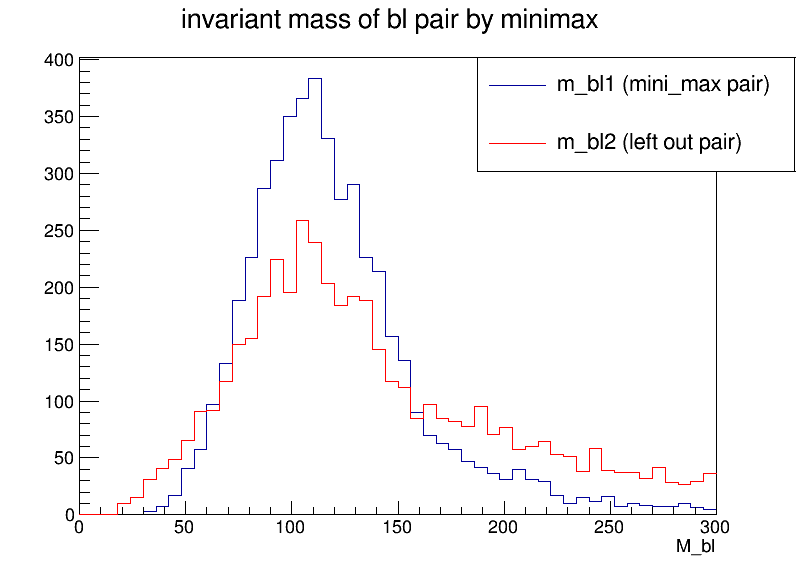

In [26]:
c3 = TCanvas('c3', 'canvas3', 0, 0, 800, 600 )
gStyle.SetOptStat(0)
m_bl1.Draw()
m_bl1.GetXaxis().SetTitle("M_bl")

m_bl2.SetLineColorAlpha(2, 1)
m_bl2.Draw('same')
leg = TLegend(0.6,0.7,1,0.9)
leg.AddEntry(m_bl1,"m_bl1 (mini_max pair)","l")
leg.AddEntry(m_bl2,"m_bl2 (left out pair)","l")
leg.Draw()
c3.Draw()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c4


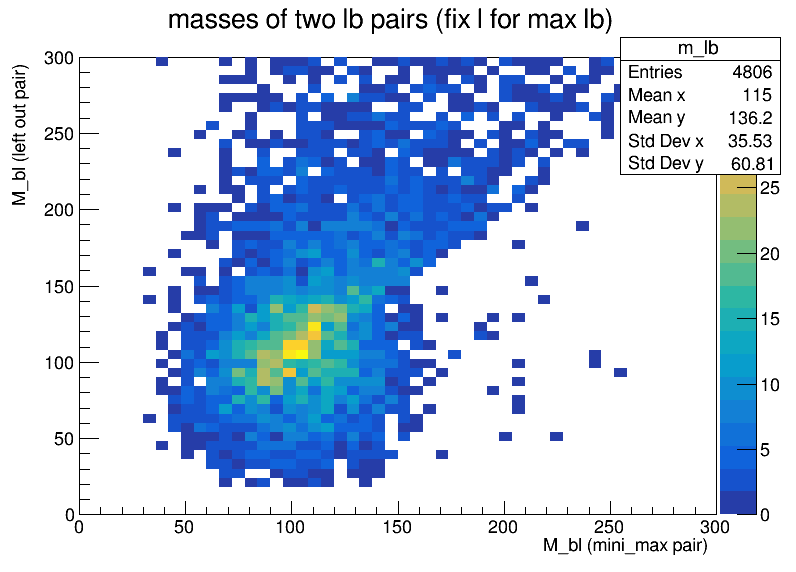

In [27]:
c4 = TCanvas('c4', 'canvas4', 0, 0, 800, 600 )
gStyle.SetOptStat(1) # delete default legend for TH1

m_lb.Draw("COLZ")
m_lb.GetXaxis().SetTitle("M_bl (mini_max pair)")
m_lb.GetYaxis().SetTitle("M_bl (left out pair)")


c4.Draw()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c5


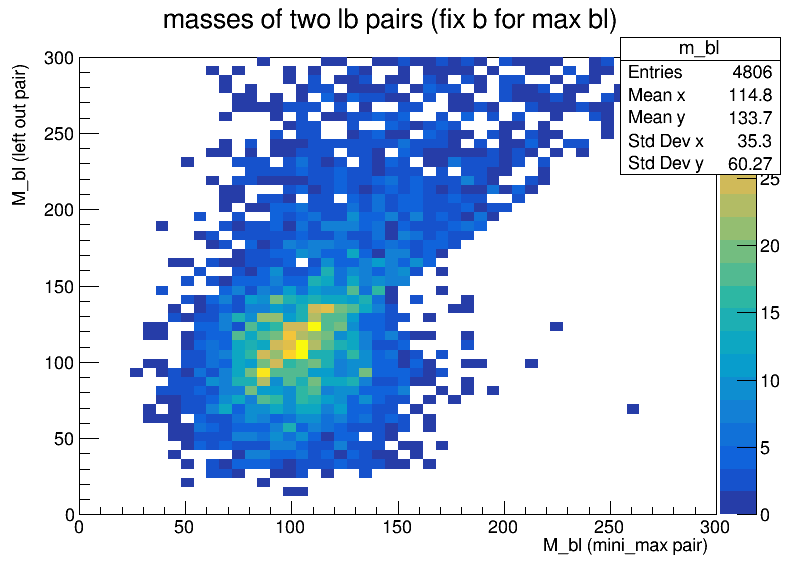

In [28]:
c5 = TCanvas('c5', 'canvas5', 0, 0, 800, 600 )
gStyle.SetOptStat(1) # delete default legend for TH1
m_bl.Draw("COLZ")
m_bl.GetXaxis().SetTitle("M_bl (mini_max pair)")
m_bl.GetYaxis().SetTitle("M_bl (left out pair)")


c5.Draw()


In [29]:
for n in range(4):
    nominal.GetEntry(n)

    p4s_el = helper.GetLorenzP4List(nominal,'el')
    p4s_mu = helper.GetLorenzP4List(nominal,'mu')
    p4s_lep = helper.getp4s_lep(p4s_el, p4s_mu)
    p4s_bjet = helper.GetLorenzP4List(nominal,'bjet')

    masses = np.empty((2,2))
    for i, p4_l in enumerate(p4s_lep):
        for j, p4_bjet in enumerate(p4s_bjet):
            # get the max m_b?li, save the idx
            masses[i,j] = (p4_l + p4_bjet).M()/1000

    idx_l, idx_b = helper.minimax(p4s_lep, p4s_bjet)

    # if (p4s_lep[idx_l] + p4s_bjet[idx_b]).M() < (p4s_lep[1 - idx_l] + p4s_bjet[1 - idx_b]).M():
    print(masses)
    print(idx_l, idx_b)



[[ 231.92487437   59.04632516]
 [ 107.95549364  240.3034353 ]]
0 0
[[ 329.62113308   66.82117164]
 [  77.61794606  221.49245222]]
1 1
[[ 108.84366044   97.92594347]
 [ 264.01185648   78.84940178]]
0 0
[[  59.3695452   151.18765028]
 [ 163.82662138   72.54595111]]
0 1
